## Full example: Optimization of the marginal likelihood and prediction

### Sinusoidal toy data

We show how the marginal likelihood can be used after training a MAP network on a simple sinusoidal regression task.
Subsequently, we use the optimized LA to predict which provides uncertainty on top of the MAP prediction.
We also show how the `marglik_training` utility method can be used to jointly train the MAP and hyperparameters.
First, we set up the training data for the problem with observation noise \\(\sigma=0.3\\):

In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training

from helper.dataloaders import get_sinusoid_example
from helper.util import plot_regression

n_epochs = 1000
torch.manual_seed(711)
# sample toy data example
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

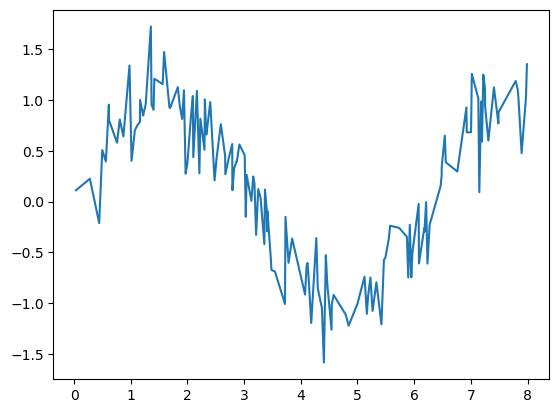

In [6]:
import matplotlib.pyplot as plt


def unzip(iterable):
    return np.array(list(zip(*iterable)))


# plot data

X_train_sorted, y_train_sorted = unzip(sorted(zip(X_train.squeeze(), y_train.squeeze())))

plt.plot(X_train_sorted, y_train_sorted)

### Training a MAP

We now use `pytorch` to train a neural network with single hidden layer and Tanh activation.
The trained neural network will be our MAP estimate.
This is standard so nothing new here, yet:

In [7]:
# create and train MAP model
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

### Fitting and optimizing the Laplace approximation using empirical Bayes

With the MAP-trained model at hand, we can estimate the prior precision and observation noise
using empirical Bayes after training.
The `Laplace` method is called to construct a LA for `"regression"` with `"all"` weights.
As default `Laplace` returns a Kronecker factored LA, we use `"full"` instead on this small example.
We fit the LA to the training data and initialize `log_prior` and `log_sigma`.
Using Adam, we minimize the negative log marginal likelihood for `n_epochs`.

In [3]:
la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

The obtained observation noise is close to the ground truth with a value of \\( \sigma \approx 0.28 \\)
without the need for any validation data.
The resulting prior precision is \\(\delta \approx 0.10\\).

### Bayesian predictive

Here, we compare the MAP prediction to the obtained LA prediction.
For LA, we have a closed-form predictive distribution on the output \\(f\\) which is a Gaussian
\\(\mathcal{N}(f(x;\theta\_{MAP}), \mathbb{V}[f] + \sigma^2)\\):

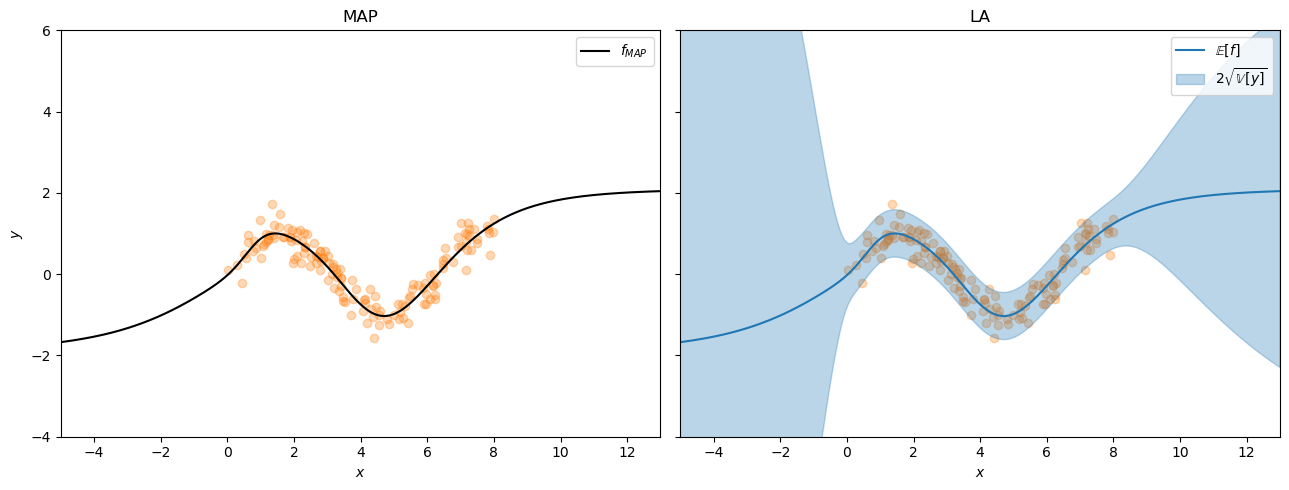

In [4]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

figsize = (13,5)
plot_regression(X_train, y_train, x, f_mu, pred_std, save=False, figsize=figsize)

In comparison to the MAP, the predictive shows useful uncertainties.
When our MAP is over or underfit, the Laplace approximation cannot fix this anymore.
In this case, joint optimization of MAP and marginal likelihood can be useful.

### Jointly optimize MAP and hyperparameters using online empirical Bayes

We provide a utility method `marglik_training` that implements the algorithm proposed in [1].
The method optimizes the neural network and the hyperparameters in an interleaved way
and returns an optimally regularized LA.
Below, we use this method and plot the corresponding predictive uncertainties again:

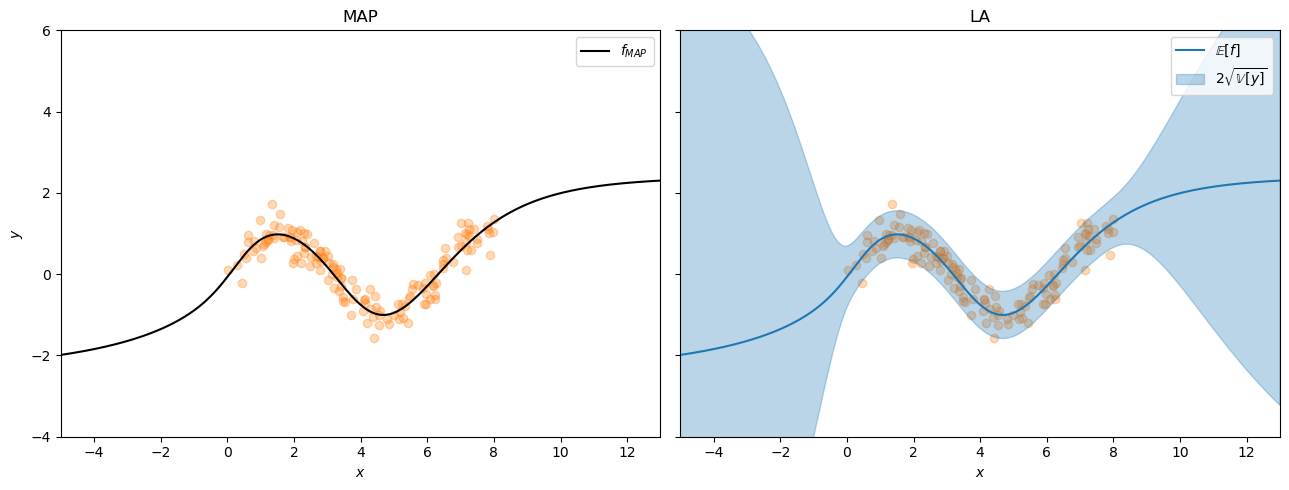

In [5]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood="regression",
    hessian_structure="full", backend=BackPackGGN, n_epochs=n_epochs,
    optimizer_kwargs={"lr": 1e-2}, prior_structure="scalar"
)

f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std, save=False, figsize=figsize)